In [3]:
from keras.models import load_model
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

Using TensorFlow backend.


In [4]:
import nltk
from nltk.util import ngrams
import spacy 
import numpy
import pandas as pd
import seaborn as sns
import re

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [5]:
#%%time
#nlp=spacy.load('en_vectors_web_lg')
%time nlp=spacy.load('./wikipedia-pubmed-and-PMC-w2v')

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


CPU times: user 52.8 s, sys: 5.68 s, total: 58.5 s
Wall time: 58.5 s


In [6]:
from spacy.pipeline import EntityRecognizer


In [7]:
#ner = EntityRecognizer(nlp.vocab)


In [8]:
def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            ##rever to word vector
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

### take SRS descripitions for classification

In [9]:
"""%%time 
inS_dir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'
srsS=pd.read_pickle(inS_dir)
srsS=pd.Series(data=srsS.values,index=pd.MultiIndex.from_arrays([srsS.index.get_level_values(0),
                                                            srsS.index.get_level_values(1).str.lower()]) )"""

"%%time \ninS_dir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'\nsrsS=pd.read_pickle(inS_dir)\nsrsS=pd.Series(data=srsS.values,index=pd.MultiIndex.from_arrays([srsS.index.get_level_values(0),\n                                                            srsS.index.get_level_values(1).str.lower()]) )"

In [10]:
"""sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'

technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)

noDupSampleS=technical_meta_data_df.groupby(['Study']).head(n=1)['Sample']

specie_m=srsS.isin(['Mus musculus','Homo sapiens'])

attrib_m=srsS.index.get_level_values(1)=='scientific_name'

mySpecieSrs=srsS[specie_m&attrib_m].index.get_level_values(0).unique()

specie_srs_m=srsS.index.get_level_values(0).isin(mySpecieSrs)

attrib_a=srsS.index.get_level_values(1)
attrib_m=attrib_a=='description'


oneInStudy_m=srsS.index.get_level_values(0).isin(noDupSampleS.values)

srsS_sub=srsS[attrib_m&specie_srs_m&oneInStudy_m].drop_duplicates()

#make sure the code doesn't sample from outliers
#20 words https://www.ijcai.org/proceedings/2017/0578.pdf
wordCountS=srsS_sub.str.count(' ')
lem_m=(wordCountS<=60)&(wordCountS>=10)
srsS_sub=srsS_sub[lem_m]

inTestStrS=srsS_sub.sample(n=100,random_state=0)

### reload model"""

"sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'\n\ntechnical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)\n\nnoDupSampleS=technical_meta_data_df.groupby(['Study']).head(n=1)['Sample']\n\nspecie_m=srsS.isin(['Mus musculus','Homo sapiens'])\n\nattrib_m=srsS.index.get_level_values(1)=='scientific_name'\n\nmySpecieSrs=srsS[specie_m&attrib_m].index.get_level_values(0).unique()\n\nspecie_srs_m=srsS.index.get_level_values(0).isin(mySpecieSrs)\n\nattrib_a=srsS.index.get_level_values(1)\nattrib_m=attrib_a=='description'\n\n\noneInStudy_m=srsS.index.get_level_values(0).isin(noDupSampleS.values)\n\nsrsS_sub=srsS[attrib_m&specie_srs_m&oneInStudy_m].drop_duplicates()\n\n#make sure the code doesn't sample from outliers\n#20 words https://www.ijcai.org/proceedings/2017/0578.pdf\nwordCountS=srsS_sub.str.count(' ')\nlem_m=(wordCountS<=60)&(wordCountS>=10)\nsrsS_sub=srsS_sub[lem_m]\n\ninTestStrS=srsS_sub.sample(n=100,random_state=0)\n\n### reload model"

In [11]:
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('./model/classes.npy')
%time model=load_model('./model/lstm.h5')

CPU times: user 21.1 s, sys: 7.24 s, total: 28.4 s
Wall time: 27.5 s


In [1230]:
!ls ./Data/

GoogleNews-vectors-negative300.bin.gz
NCBI_harmonized_name_df.tsv
NCIT_table.pickle
PMC-ids.csv.gz
PMC-ids.csv.gz.1
PubMed-w2v.bin
PubMed-w2v.bin.1
displacy.html
hmaps_batch
medtag
medtag.tar.gz
pmc_word2_vec.gensim
pmc_word2_vec.gensim.trainables.syn1neg.npy
pmc_word2_vec.gensim.wv.vectors.npy
pmc_word2_vec.pandas.threshold.10.pickle
pmc_word2_vec.pandas.threshold.100.pickle
pmc_word2_vec.pandas.threshold.200.pickle
pmc_word2_vec.txt
spacy_bio_nlp
text.txt
validation.ngram.json.txt
validation_cell line.pickle
validation_cell line.xlsx
validation_description.pickle
validation_description.xlsx
validation_lines.txt
validation_title.pickle
validation_title.xlsx
validation_{}.txt
wikipedia-pubmed-and-PMC-w2v.bin
wikipedia-pubmed-and-PMC-w2v.txt


In [1492]:
selectedValidAttrib='description'
inTestStrFlatS=pd.read_pickle('./Data/validation_{}.pickle'.format(selectedValidAttrib)).head(n=100)

In [1493]:
#inTestStrS.str.replace('[0-9 ]{2,}')

#### get baseline empty state

In [1494]:
val_docs = list(nlp.pipe(' '))
val_X=get_features(val_docs,max_length=model.input_shape[1])

emptyState=model.predict_proba(val_X)[0,:]

### calculate NER score for each segment

In [1495]:
import nltk
#from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

In [1496]:
stopWords=stopwords.words('english')
print(stopWords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [1497]:
phraseMax=7

In [1498]:
inTestStrS=inTestStrFlatS.str.split('[;.,]',expand=True).stack()

In [1499]:
inTestStrS=inTestStrS.str.replace('\s+',' ')

In [1500]:
myML=[]
myKeyL=[]
for i_th,(key,sent) in enumerate(tqdm(inTestStrS.items(),total=len(inTestStrS))):
    sent=re.sub(r'[^a-zA-Z0-9 ]+', ' ', sent)## remove non alpha numeric 
    tokens=re.split(pattern=' ',string=sent)
    #
    tokens=list(filter(lambda token:(token!='') and (token not in stopWords)  ,tokens))
    sent=' '.join(tokens)
    ###keep track of each token
    scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
    #for n_gram in range(1,len(tokens)+1):
    myNMax=min( [len(tokens),phraseMax])
    #print (myNMax)
    for n_gram in range(1,myNMax+1):
        grams=list(map(lambda L:" ".join(L),list(ngrams(tokens,n_gram))))
        val_docs = list(nlp.pipe(grams))
        val_X=get_features(val_docs,max_length=model.input_shape[1])
        predictM=model.predict_proba(val_X)
        tmpDf=pd.DataFrame(data=predictM,columns=le.classes_,index=grams)
        empty_mask=(tmpDf-emptyState).abs().sum(axis=1)<0.01
        moreThanTwoValToken_mask=(val_X!=0).sum(axis=1)>=2
        tmpDf[empty_mask&moreThanTwoValToken_mask]=0
        for i,gram in enumerate(tmpDf.index): #i: track the each token position
            #for j,one_gram in enumerate(gram.split(' ')):
            i_end=i+n_gram+1
            textBefore=" ".join(tokens[:i]) + ('' if i==0 else ' ')
            start_char_pos=len(textBefore)
            myKeyL.append(key+(i_th,sent,n_gram,i,i_end,gram,start_char_pos)) 
            myML.append(tmpDf.iloc[i])





  0%|          | 0/577 [00:00<?, ?it/s]



  1%|          | 3/577 [00:00<00:24, 23.10it/s]



  1%|          | 5/577 [00:00<00:28, 19.77it/s]



  1%|          | 7/577 [00:00<00:32, 17.47it/s]



  2%|▏         | 11/577 [00:00<00:27, 20.64it/s]



  3%|▎         | 15/577 [00:00<00:25, 21.85it/s]



  3%|▎         | 17/577 [00:00<00:26, 21.34it/s]



  3%|▎         | 20/577 [00:00<00:26, 21.39it/s]



  4%|▍         | 22/577 [00:01<00:28, 19.82it/s]



  4%|▍         | 25/577 [00:01<00:27, 20.38it/s]



  5%|▍         | 27/577 [00:01<00:27, 20.02it/s]



  5%|▌         | 30/577 [00:01<00:29, 18.41it/s]



  6%|▌         | 32/577 [00:01<00:29, 18.18it/s]



  6%|▋         | 37/577 [00:01<00:27, 19.63it/s]



  7%|▋         | 40/577 [00:02<00:27, 19.51it/s]



  7%|▋         | 43/577 [00:02<00:26, 19.86it/s]



  8%|▊         | 46/577 [00:02<00:26, 19.71it/s]



  8%|▊         | 49/577 [00:02<00:26, 19.95it/s]



  9%|▉         | 52/577 [00:02<00:25, 20.22it/s]



 10%|▉         | 56/

 61%|██████    | 351/577 [00:17<00:11, 20.12it/s]



 62%|██████▏   | 355/577 [00:17<00:10, 20.23it/s]



 62%|██████▏   | 358/577 [00:17<00:10, 20.19it/s]



 63%|██████▎   | 361/577 [00:17<00:10, 20.22it/s]



 63%|██████▎   | 364/577 [00:17<00:10, 20.25it/s]



 64%|██████▎   | 367/577 [00:18<00:10, 20.25it/s]



 64%|██████▍   | 370/577 [00:18<00:10, 20.15it/s]



 65%|██████▍   | 373/577 [00:18<00:10, 20.18it/s]



 65%|██████▌   | 376/577 [00:18<00:09, 20.23it/s]



 66%|██████▌   | 379/577 [00:18<00:09, 20.19it/s]



 66%|██████▌   | 382/577 [00:18<00:09, 20.22it/s]



 67%|██████▋   | 385/577 [00:19<00:09, 20.23it/s]



 68%|██████▊   | 390/577 [00:19<00:09, 20.32it/s]



 68%|██████▊   | 393/577 [00:19<00:09, 20.33it/s]



 69%|██████▊   | 396/577 [00:19<00:08, 20.38it/s]



 69%|██████▉   | 399/577 [00:19<00:08, 20.41it/s]



 70%|██████▉   | 402/577 [00:19<00:08, 20.42it/s]



 70%|███████   | 405/577 [00:19<00:08, 20.39it/s]



 71%|███████   | 408/577 [00:19<00:08, 20.42it

In [1501]:
#tmpDf

In [1502]:
#textBefore

In [1503]:
#tmp=myKeyL[2]
#tmp[1][6:10]

In [1504]:
#tmpDf.iloc[i]

In [1505]:
#
#tmpDf.iloc[i]

In [1506]:
"""thresholdS=pd.Series(
   {'SCIENTIFIC_NAME': 0.26689231395721436,
 'cell type': 0.10027739964425564,
 'disease': 0.15823280811309814,
 'genotype': 0.09954400360584259,
 'geo_loc_name': 0.6163255572319031,
 'sex': 0.6458048224449158}
)"""

"thresholdS=pd.Series(\n   {'SCIENTIFIC_NAME': 0.26689231395721436,\n 'cell type': 0.10027739964425564,\n 'disease': 0.15823280811309814,\n 'genotype': 0.09954400360584259,\n 'geo_loc_name': 0.6163255572319031,\n 'sex': 0.6458048224449158}\n)"

In [1518]:
mergedDf=pd.concat(myML,keys=myKeyL,axis=1).T

In [1519]:
#mergedDf

In [1520]:
mergedDf.index.names=['srs','attribute','n_sent']+['i_thSrs','orig_text','n','i','i_end','token','ith_char_pos']

In [1521]:
#key

## entity recognition

In [1522]:
n_threshold=2

In [1523]:
mergedDf_sub=mergedDf[mergedDf.index.get_level_values('n')>=n_threshold]

In [1527]:
#len(scoreMargin_m),len()

In [1528]:
maxS=mergedDf_sub.max(axis=1)#>0.3
secondBestScoreS=mergedDf_sub.quantile(0.999,interpolation='lower',axis=1)
scoreMargin_m=(maxS-secondBestScoreS)>0.1
m_val=scoreMargin_m&(~mergedDf_sub.index.get_level_values('token').str.contains('[0-9 ]+ [0-9 ]+'))


In [1529]:
tmpDf=pd.DataFrame({'predicted':mergedDf_sub[m_val].idxmax(axis=1),'score':mergedDf_sub[m_val].max(axis=1)})

In [1530]:
scoreSortedDf=tmpDf[m_val].sort_values(['orig_text','i','score'],ascending=False).reset_index(
)



/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [1531]:
## get all overlapping regions
v=scoreSortedDf.copy()
scoreSortedDf=scoreSortedDf.assign(OverlapGroup=(len(inTestStrS)*v.i_thSrs+ 
                                          (v.i_end - v.i.shift(-1)).shift().lt(0).cumsum()))


In [1532]:
scoreSortedDf.head()

,srs,attribute,n_sent,i_thSrs,orig_text,n,i,i_end,token,ith_char_pos,predicted,score,OverlapGroup
0,SRS345653,description,3,280,vancomycin 500 mg l,2,2,5,mg l,15,treatment,0.171350,161560
1,SRS345653,description,3,280,vancomycin 500 mg l,2,1,4,500 mg,11,treatment,0.211407,161560
2,ERS710488,description,5,416,using low input protocol,2,2,5,input protocol,10,treatment,0.137796,240032
3,ERS710488,description,5,416,using low input protocol,2,1,4,low input,6,genotype,0.394349,240032
4,DRS019017,description,2,188,using Dynabeads mRNA DIRECT Micro Kit Invitrogen,2,4,7,Micro Kit,28,geo_loc_name,0.527912,108476


In [1533]:
hitDf=scoreSortedDf.sort_values(['OverlapGroup','score'],ascending=False).drop_duplicates(['OverlapGroup','predicted']
                                                                                   ).sort_values('orig_text')

In [1534]:
hitDf['token_len']=hitDf['token'].str.len()

In [1535]:
hitDf['recovered_txt']=hitDf.apply(
    lambda tmpS2:tmpS2.loc['orig_text'][tmpS2.loc['ith_char_pos']:(tmpS2.loc['ith_char_pos']+tmpS2.loc['token_len'])],axis=1)

In [1536]:
print ('is it extraction: ',(hitDf.recovered_txt==hitDf.token).all())

is it extraction:  True


{"content":"cd players and tuners","annotation":[{"label":["Category"],"points":[{"start":0,"end":1,"text":"cd"}]},{"label":["Category"],"points":[{"start":3,"end":9,"text":"players"}]},{"label":["Category"],"points":[{"start":15,"end":20,"text":"tuners"}]}],"extras":{"Name":"columnName","Class":"ColumnValue"}}
\
Content contains input text, annotation has the labeled content, extras is for some extra columns that you want to show with each row.



### visualize using spacy

In [1537]:
myClassToId={}
for myClass in le.classes_:
    myClassToId[myClass]=nlp.vocab.strings.add(myClass)


In [1538]:
classToSpacyId=pd.Series(myClassToId)

In [1539]:
inDisplayHitDf=hitDf.copy()

In [1540]:
inDisplayHitDf['predicted_entity_id']=classToSpacyId.loc[inDisplayHitDf['predicted']].values

In [1541]:
#inDisplayHitDf

In [1542]:
#inTestStrFlatS

### classify texts

In [1543]:
orig_text_S=inDisplayHitDf.drop_duplicates(['srs','n_sent','orig_text']).set_index(['srs','n_sent'])['orig_text']

In [1544]:
orig_textL=orig_text_S

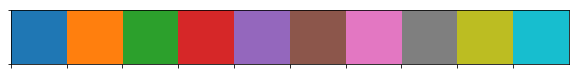

In [1545]:
import matplotlib
current_palette = sns.color_palette()
sns.palplot(current_palette)
colors = {ent.upper():matplotlib.colors.to_hex(myColor)  for myColor,ent in zip(current_palette,classToSpacyId.index)}
options = {'ents': classToSpacyId.index.str.upper(),
           'colors': colors}

In [1546]:
hitDf_groupby=inDisplayHitDf.groupby('srs')

In [1547]:
orig_textL

srs         n_sent
ERS098274   4         000 cm2 laminin coated vessels 10 ug ml lamini...
            1         1 1 mixture DMEM F 12 Neurobasal media Invitro...
SRS703382   4                                              1 DMSO 4 hrs
SRS150400   11                           1 mM non essential amino acids
            9                                      1 mM sodium pyruvate
SRS010066   2                                          10 ug mL insulin
            3                10 ug mL transferrin differentiation media
SRS988108   7                                          1038 nature14582
ERS710418   6                                                 1073 pnas
ERS042908   4                                           10ug mL Insulin
ERS508289   5         1ug total RNA used make poly A selected barcod...
SRS150400   8                                          2 mM L glutamine
ERS1269995  3                              2 mM L glutamine G7513 100ML
ERS215384   2         2001 Fractionation Ter1

In [1548]:
doc_L=[]
hitDf_groupby=inDisplayHitDf.groupby('orig_text')
for key,orig_text in orig_textL.items():#[10]
    

    inRecordDisplayDf=hitDf_groupby.get_group(orig_text)

    doc=nlp(orig_text)

    for _,tmpS in inRecordDisplayDf.iterrows():
        EVENT=tmpS['predicted_entity_id']
        entity=(EVENT,tmpS['i'],tmpS['i_end']-1)# this the correct one
        #print (entity)
        doc.ents+=(entity,)
        
        #optional
        title="{}: sentence #{}  ".format(key[0],key[1])
        doc.user_data['title']=title
    doc_L.append(doc)
    

In [1549]:
#orig_textL[0]

In [1550]:
#inDisplayHitDf

In [1552]:
#spacy.displacy.render(doc, style='ent',jupyter=True,options=options)

html=spacy.displacy.render(doc_L, style='ent',page=True,options=options)

with open('./Data/displacy.{}.html'.format(selectedValidAttrib),'w') as f:
    f.write(html)

In [ ]:
#!echo $PWD/./Data/displacy.html

In [ ]:
asdasdasd

In [1491]:
asdfasf

NameError: name 'asdfasf' is not defined

In [1463]:
nerName='cell type'
nlp.vocab.strings.add(nerName)
EVENT = nlp.vocab.strings[nerName]


In [1464]:
EVENT

188603156775490070

In [1390]:
doc=nlp(u"t cell")

In [1391]:
#use 
entity=(EVENT,0,len(u"t cell"))
doc.ents+=(entity,)

In [1392]:
spacy.displacy.render(doc, style='ent',jupyter=True)


In [1393]:


def add_event_ent(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    entity = (EVENT, start, end)
    doc
    doc.ents += (entity,)

In [1394]:
myToke.label=''

NameError: name 'myToke' is not defined

In [1395]:
doc.ents+=tuple(['cell type'])

ValueError: too many values to unpack (expected 4)

In [1396]:
#span=doc[:]

In [1397]:
#nlp.

In [1398]:
#span.label='cell type'

# export to dataturk

In [ ]:
import json

In [ ]:
def myF(tmpS1):
    return {"label":[tmpS1.loc['predicted']],"points":{'start':tmpS1.loc['i'],
     'end':tmpS1.loc['i_end']-1,'text':tmpS1.loc['token']},

        }

inAnnotDf=hitDf.copy()
myL=[]
for text,subDf in inAnnotDf.groupby(['orig_text']):
    oneAnnotatedLine={"content":text,'annotation':list(subDf.apply(myF,axis=1)),
                                "extras":None,
        "metadata":{"first_done_at":1535058971000,
                                     "last_updated_at":1535058971000,"sec_taken":0,
                                "last_updated_by":"EEOBDlEO48T6gzo0KHvT0IkqZnn2"}}
    myL+=[json.dumps(oneAnnotatedLine)]
    

In [ ]:
#myL[0]

In [ ]:
with open( './Data/validation.ngram.json.txt','w')as f:
    f.write("\n".join(myL[:1]))


In [ ]:
!echo $PWD/./Data/validation.ngram.json.txt

In [ ]:
print(",".join(le.classes_))

In [ ]:
!head 

In [ ]:
oneAnnotatedLine['annotation'][0]

In [ ]:
exampleDict={"content":"cd players and tuners","annotation":[{"label":["Category"],"points":[{"start":0,"end":1,"text":"cd"}]},{"label":["Category"],"points":[{"start":3,"end":9,"text":"players"}]},{"label":["Category"],"points":[{"start":15,"end":20,"text":"tuners"}]}],"extras":{"Name":"columnName","Class":"ColumnValue"}}
exampleDict

In [ ]:
#{"label":["Category"],"points":[{"start":15,"end":20,"text":"tuners"}]}
#myL=[]
#{"content":text,"annotation":}

In [ ]:
inAnnotDf.iloc[:1].to_json()

In [ ]:
text

In [ ]:
hitDf['i_thSrs'].value_counts()

In [ ]:
hitDf['i_thSrs'].value_counts()

In [ ]:
hitDf.sort_values(['i_thSrs'])

### scratch

In [ ]:
myNameL=list(VC.index.names)
myNameL[-1]='Predicted_NE'
VC.index.names=myNameL

In [ ]:
#### for each n-gram, there is the same start site, use 

In [ ]:
#.drop_duplicates(['orig_text','Predicted_NE'])


In [ ]:
#mergedDf
#take on any length, 

In [ ]:
tmpDf=(mergedDf>thresholdS).loc['ESCs WT replicate1 mRNA Mad2l2'].stack().reset_index()

In [ ]:
tmpDf.columns=['n','n-gram','attrib','passThreshold']

In [ ]:
#tmpDf['n-gram']

In [ ]:
tmpDf[tmpDf.passThreshold]
      

In [ ]:
tmpS[tmpS].groupby(level=[1,2]).size()

In [ ]:
tmpDf2.idxmax(axis=1)

In [ ]:
mergedDf=pd.concat(myML,keys=list(inTestStrS))

In [ ]:
numeric_token_m=mergedDf.index.get_level_values(0).str.contains('^\d+$')

In [ ]:
mergedSubDf=mergedDf[~numeric_token_m].copy()#.loc[:,mergedDf.columns!='age']

In [ ]:
threshold=0.800000
mergedSubDf['undetected']=threshold
#noAmbigM=(mergedSubDf>=threshold).sum(axis=1)>=1 #this mark screw up the confoudning boundary 
mergedSubDf.loc[:,'undetected']=threshold

In [ ]:
predDf=mergedSubDf.idxmax(axis=1).to_frame()

In [ ]:
predDf.index.names=['Freetext','Token']
predDf['token_numeric']=predDf.index.get_level_values('Token').str.contains('^\d+$')

In [ ]:
excel=pd.ExcelWriter('./Results/for_curation.xlsx')
predDf[~predDf['token_numeric']].to_excel(excel)
excel.close()

# scratch

In [ ]:
asdasd

In [ ]:
predDf[~predDf['token_numeric']]

In [ ]:
!echo $PWD/./Results/for_curation.xlsx

In [ ]:
#predDf

In [ ]:
!echo $PWD/./Results/for_curation.xlsx

In [ ]:
predDf[~predDf['token_numeric']].to_csv('tmp.csv')

In [ ]:
#!rm tmp.csv

In [ ]:
import numpy as np

In [ ]:
#replace with duplicated states
#emptyStat=np.array([0.42332533, 0.4360587 , 0.61020947, 0.42082471, 0.4110575 ,
#       0.42533568, 0.47932082])

In [ ]:
emptyState=mergedSubDf.groupby(mergedSubDf.columns.tolist(),as_index=False).size().sort_values().index[-1]
#emptyStat=np.array([0.42332533, 0.4360587 , 0.61020947, 0.42082471, 0.4110575 ,
#       0.42533568, 0.47932082])
print (emptyState)

In [ ]:
noPredM=((mergedSubDf-emptyState).abs()<0.1).all(axis=1)
mergedSubDf[(~noPredM)&(mergedSubDf>0.5).sum(axis=1)==1]

In [ ]:
#good examples: HAP1 LMTK3-KO cells, stimulated with WNT3, replicate R2

In [ ]:
mergedSubDf.loc['HAP1 CCK4-KO cells, stimulated with RESV, replicate R1']

In [ ]:
mergedSubDf[].iloc[0].values

In [ ]:
sns.heatmap(data=scoreDf.T)

In [ ]:
##among the ones with >0.5, take the ones that are unique
sns.heatmap(data=(scoreDf>0.6).T)

In [ ]:
sns.heatmap(data=scoreDf.T)

In [ ]:
### among the ones with clear boundry, it can classify well. 


"""
argue that it can salvage the data correctly. Among those sentences, 

take >0.5 as boundary, run top 10000 sentences 
"""
scoreDf

### show one

In [ ]:
#sent='Human histone H3 di-methylated at lysine 4 (H3K4me2) in human blood CD4+ T cells, targeted using Abcam antibody ab7766'#inTestStrS.iloc[5]
sent='RNA-seq of total RNA from Z/Edn2; Six3-Cre mouse retina	'
print(sent)

In [ ]:
#sent=re.sub(r'[^a-zA-Z0-9 ]+', ' ', sent)
#print (sent)
tokens=re.split(pattern=' ',string=sent)
s=tokens
#print (tokens)
scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
#for n_gram in range(1,len(tokens)+1):
#for n_gram in range(1,len(tokens)):
n_gram=8
grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
#print (grams)
val_docs = list(nlp.pipe(grams))
val_X=get_features(val_docs,max_length=model.input_shape[1])
tmpDf=pd.DataFrame(data=model.predict_proba(val_X),columns=le.classes_,index=grams)
#tmpDf=pd.DataFrame(data=predictM,columns=le.classes_,index=grams)
empty_mask=(tmpDf-emptyState).abs().sum(axis=1)<0.01
tmpDf[empty_mask]=0

fig,ax=plt.subplots(figsize=(3,2.5*4))
sns.heatmap(tmpDf,annot=True,ax=ax,vmin=0,vmax=1.0,fmt='.2f',cbar=None)
#ax.set_xticklabels([])
"""break

#each n gram only advange 
for i,gram in enumerate(tmpDf.index):# for ec
    for j,one_gram in enumerate(gram.split(' ')):
        scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))
"""

In [ ]:
#for each one, makes a prediction on the term, to see what it is supposed to be. 

### test one

In [ ]:
sent=re.sub(r'[^a-zA-Z0-9 ]+', ' ', sent)
#print (sent)
tokens=re.split(pattern=' ',string=sent)
s=tokens
#print (tokens)
scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
#for n_gram in range(1,len(tokens)+1):
for n_gram in range(1,len(tokens)):
    grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
    #print (grams)
    val_docs = list(nlp.pipe(grams))
    val_X=get_features(val_docs,max_length=model.input_shape[1])
    predictM=model.predict_proba(val_X)

    tmpDf=pd.DataFrame(data=predictM,columns=le.classes_,index=grams)
    empty_mask=(tmpDf-emptyState).abs().sum(axis=1)<0.01
    tmpDf[empty_mask]=0

    """
    each n gram only advange 
    """
    for i,gram in enumerate(tmpDf.index):# for ec
        for j,one_gram in enumerate(gram.split(' ')):
            scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))


In [ ]:
threshold=0.2
scoreDf[scoreDf<=threshold]=0
scoreDf['undetected']=threshold

scoreDf.idxmax(axis=1)

In [ ]:
sns.heatmap(scoreDf,annot=True)

In [ ]:
tokens

In [ ]:
sns.heatmap(scoreDf.T,annot=True)

In [ ]:
sexS=srsS[srsS.index.get_level_values(1)=='sex']

In [ ]:
sexS.value_counts()

In [ ]:
tmpSubSrsS1=srsS[srsS.str.contains('rna',case=False)]

In [ ]:
tmpSubSrsS1

In [ ]:
#!python -m spacy download en_core_web_sm
